<a href="https://colab.research.google.com/github/bam098/plant_pathology/blob/main/plant_pathology_basic_3_classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [1]:
!pip uninstall fastai -q -y
!pip install fastai -q

In [2]:
import fastai
print(fastai.__version__)

2.1.7


In [3]:
from fastai.vision.all import *
from sklearn.metrics import roc_auc_score

In [4]:
PATH = Path('/content/drive/MyDrive/fastai/data/plant-pathology/')
DATA_DIR = Path('/content/drive/MyDrive/fastai/data/plant-pathology/')
IMG_DIR = PATH/'images'
TRAIN_CSV = 'train.csv'
TEST_CSV = 'test.csv'
SS_CSV = 'sample_submission.csv'


In [6]:
SEED = 42
set_seed(42)
IMG_SIZE = 224
BS = 32
ARCH = resnet18

In [10]:
DATA_DIR.ls()

(#4) [Path('/content/drive/MyDrive/fastai/data/plant-pathology/sample_submission.csv'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/train.csv'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/test.csv'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images')]

In [11]:
#There are 3642 train and test images in the images folder
(IMG_DIR).ls()

(#3642) [Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1733.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1734.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1713.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1738.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1735.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_173.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1769.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_179.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1786.jpg'),Path('/content/drive/MyDrive/fastai/data/plant-pathology/images/Train_1754.jpg')...]

# Understanding the data

In [50]:
#lets take a look at the train csv
train_df = pd.read_csv(DATA_DIR/TRAIN_CSV)
test_df = pd.read_csv(DATA_DIR/TEST_CSV)

In [13]:
#there are 4 classes - multiclass problem
train_df.head(5)

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


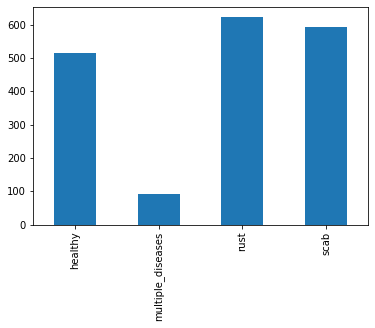

In [14]:
#lets look at the label counts
#lowest count is multiple_disease
LABELS = ['healthy', 'multiple_diseases', 'rust', 'scab']
train_df[LABELS].sum().plot(kind='bar')

In [15]:
#all the other classes except multiple_diseases are about equal. Multiple_diseases is a bit underrepresented
round((train_df[LABELS].sum()/(train_df[LABELS].sum().sum()))*100, 2)

healthy              28.34
multiple_diseases     5.00
rust                 34.16
scab                 32.51
dtype: float64

### Reduce number of classes

Insetead of 4 classes we could have just 3: healthy, rust and scab

In [100]:
train_df_orig = pd.read_csv(DATA_DIR/TRAIN_CSV)

In [103]:
train_df_orig[(train_df_orig.multiple_diseases == 1) & ((train_df_orig.rust == 1) | (train_df_orig.scab == 1))]

,image_id,healthy,multiple_diseases,rust,scab


In [42]:
def amplify_classes(df):
  def amplify_classes_in_row(row):
    if row['rust'] == 1 and row['scab'] == 1:
      row['multiple_diseases'] = 1
      row['rust'] = 0
      row['scab'] = 0
    else:
      row['multiple_diseases'] = 0
    
    return row

  return df.apply(amplify_classes_in_row, axis=1)[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]

def reduce_classes(df):
  def reduce_classes_in_row(row):
    if row['multiple_diseases'] == 1:
      row['rust'] = 1
      row['scab'] = 1
    
    return row
  
  return df.apply(reduce_classes_in_row, axis=1).drop(columns=['multiple_diseases'])

In [46]:
assert amplify_classes(reduce_classes(train_df)).equals(train_df), 'Those 2 operations should be reversable without side effects'

In [51]:
train_df = reduce_classes(train_df)

In [54]:
train_df

,image_id,healthy,rust,scab
0,Train_0,0,0,1
1,Train_1,0,1,1
2,Train_2,1,0,0
3,Train_3,0,1,0
4,Train_4,1,0,0
...,...,...,...,...
1816,Train_1816,0,0,1
1817,Train_1817,1,0,0
1818,Train_1818,1,0,0
1819,Train_1819,0,1,0


In [64]:
LABELS=['healthy', 'rust', 'scab']

In [65]:
#total train count
train_df[LABELS].sum().sum()

1912

In [66]:
fn = get_image_files(DATA_DIR/IMG_DIR)[0]
img = PILImage.create(fn)

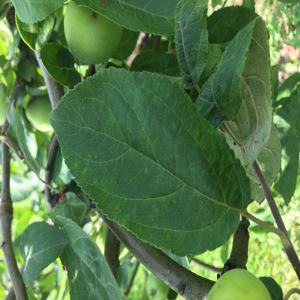

In [67]:
img.resize((300,300))

In [68]:
#lets make a label column
train_df['label'] = train_df[LABELS].idxmax(1)

In [69]:
train_df['label'].value_counts()

rust       713
scab       592
healthy    516
Name: label, dtype: int64

# Data and Dataloader

In [70]:
db = DataBlock(
            blocks=(ImageBlock, CategoryBlock()), 
            getters=[ColReader('image_id', pref=IMG_DIR, suff='.jpg'), ColReader('label')], 
            splitter=RandomSplitter(valid_pct=0.1, seed=SEED),
            item_tfms=Resize(IMG_SIZE),
            batch_tfms=aug_transforms(size=IMG_SIZE, max_rotate=30., min_scale=0.75, flip_vert=True, do_flip=True)
             )

In [71]:
dls = db.dataloaders(source=train_df, bs=BS)

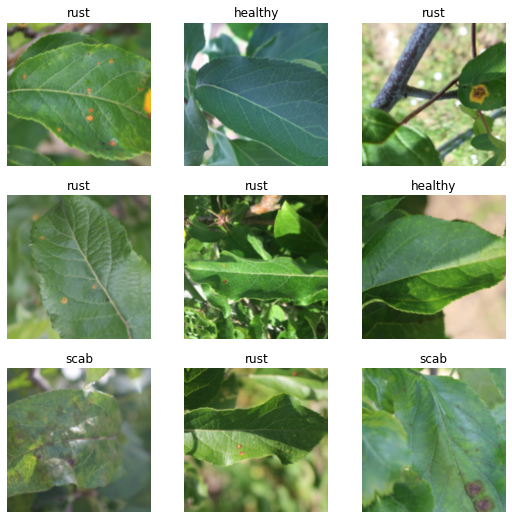

In [72]:
dls.show_batch()

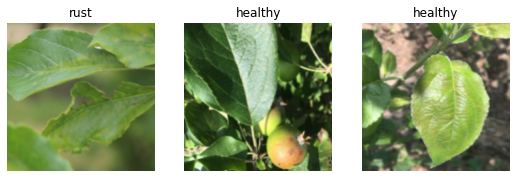

In [73]:
dls.train.show_batch(max_n=3)

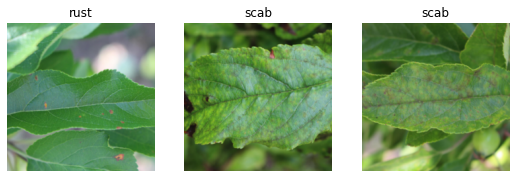

In [74]:
dls.valid.show_batch(max_n=3)

In [75]:
dls.col_reader

(#2) [ColReader -- {'cols': 'image_id', 'pref': Path('/content/drive/MyDrive/fastai/data/plant-pathology/images'), 'suff': '.jpg', 'label_delim': None}:
encodes: decodes: ,ColReader -- {'cols': 'label', 'pref': '', 'suff': '', 'label_delim': None}:
encodes: decodes: ]

In [76]:
dls.valid.bs

32

# Metric

In [77]:
# the metric was copied from https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763

def comp_metric(preds, targs, labels=range(len(LABELS))):
    # One-hot encode targets
    targs = np.eye(4)[targs]
    return np.mean([roc_auc_score(targs[:,i], preds[:,i]) for i in labels])

def healthy_roc_auc(*args):
    return comp_metric(*args, labels=[0])

def multiple_diseases_roc_auc(*args):
    return comp_metric(*args, labels=[1])

def rust_roc_auc(*args):
    return comp_metric(*args, labels=[2])

def scab_roc_auc(*args):
    return comp_metric(*args, labels=[3])

# Training

In [78]:
learn = cnn_learner(dls, ARCH, 
                    loss_func=CrossEntropyLossFlat(),
                    metrics=[accuracy, AccumMetric(comp_metric, flatten=False)]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.6/dist-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=6.309573450380412e-07)

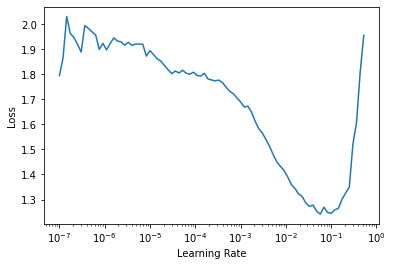

In [79]:
learn.lr_find()

In [91]:
LR = 1e-2 #from lr_finder

In [92]:
learn.fine_tune(1, LR)

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.863000,0.475203,0.851648,0.947552,01:31


epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.444537,0.257566,0.917582,0.983089,01:18


In [93]:
learn.fit_one_cycle(5, slice(1e-6, LR))

epoch,train_loss,valid_loss,accuracy,comp_metric,time
0,0.262739,0.189925,0.950549,0.977790,01:18
1,0.304347,0.376958,0.917582,0.984864,01:19
2,0.295764,0.247405,0.928571,0.990157,01:18
3,0.264502,0.151147,0.939560,0.993646,01:19
4,0.219360,0.150433,0.945055,0.993298,01:19


**Saved model**

In [120]:
learn.save(f"{DATA_DIR}/3_cls_{ARCH.__name__}_model")

Path('/content/drive/MyDrive/fastai/data/plant-pathology/3_cls_resnet18_model.pth')

In [124]:
learn = learn = cnn_learner(dls, ARCH, 
                    loss_func=CrossEntropyLossFlat(),
                    metrics=[accuracy, AccumMetric(comp_metric, flatten=False)]).to_fp16()

learn = learn.load(f"{DATA_DIR}/3_cls_{ARCH.__name__}_model")

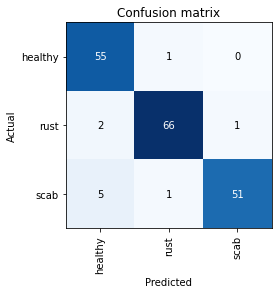

In [94]:
#model is actually missing interp scab as health
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

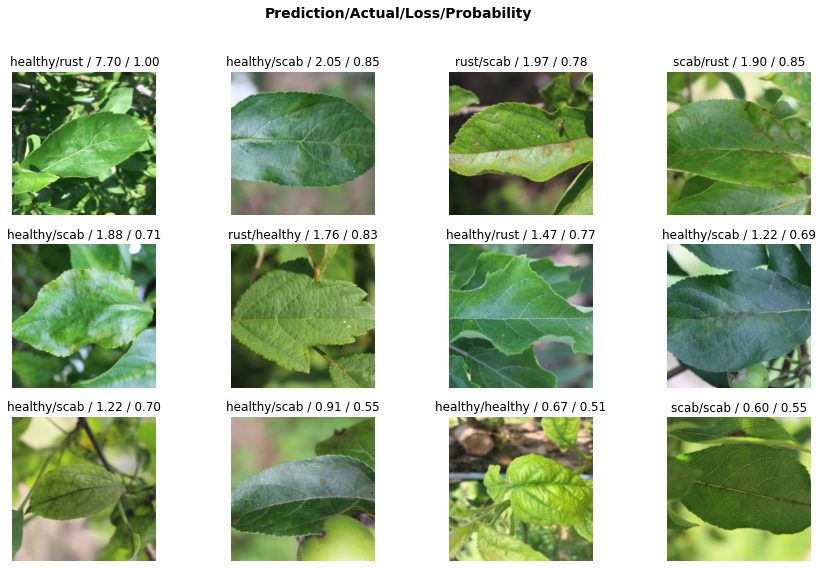

In [95]:
#understandable why multiple_disease looks like rust
interp.plot_top_losses(12, figsize=(15,9), nrows=3)

In [96]:
test_dl = dls.test_dl(test_df)

In [97]:
test_preds, _ = learn.get_preds(dl=test_dl)

In [98]:
test_preds

tensor([[9.2076e-04, 9.9895e-01, 1.2894e-04],
        [3.7483e-04, 9.9962e-01, 3.9040e-06],
        [4.5392e-05, 1.2533e-04, 9.9983e-01],
        ...,
        [2.8489e-03, 9.9660e-01, 5.5336e-04],
        [9.9975e-01, 1.8521e-04, 6.3016e-05],
        [9.5640e-02, 4.1342e-01, 4.9094e-01]])

In [104]:
sub_df = pd.concat([test_df, pd.DataFrame(test_preds, columns=LABELS)], axis=1)

In [106]:
sub_df['multiple_diseases'] = sub_df['rust'] * sub_df['scab']

In [112]:
def normalize_row(row):
  sum = row['healthy'] + row['rust'] + row['scab'] + row['multiple_diseases']

  row['healthy'] /= sum
  row['rust'] /= sum
  row['scab'] /= sum
  row['multiple_diseases'] /= sum

  return row

sub_df = sub_df.apply(normalize_row, axis=1)

In [114]:
sub_df = sub_df[['image_id', 'healthy', 'multiple_diseases', 'rust', 'scab']]

In [115]:
sub_df.to_csv(f'{DATA_DIR}/submission_3_cls.csv', index=False)

# Things we can try
1. try other (bigger) architecture -->maybe from timm or torchvision
2. other image augmentation
3. factoring the multiple_disease label data by different factors
4. in the above learner, it confuses btw rusty/multiple_disease and scab/healthy (maybe we can look into this also)


#interesting concepts used in [this notebook](https://www.kaggle.com/lextoumbourou/plant-pathology-2020-eda-training-fastai2?scriptVersionId=33070763) 

1. multilabel kfold crossvalidation
2. data augmentation (?) - increasing the amount of lowest label data 
3. transfer learning - densenet
4. freeze/unfreeze training
6. LabelSmoothingCrossEntropy
5. to_fp16 - understand this was mentioned in the "bags of tricks for image classification with cnn paper" (anyone has any resources to learn about it)

#other interesting concepts
1. AccumMetric - how does this work?? 